#### 1. Import necessary libraries

In [53]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

#### 2. Set Parameters and Load files

In [54]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [55]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato Desease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [56]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [57]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


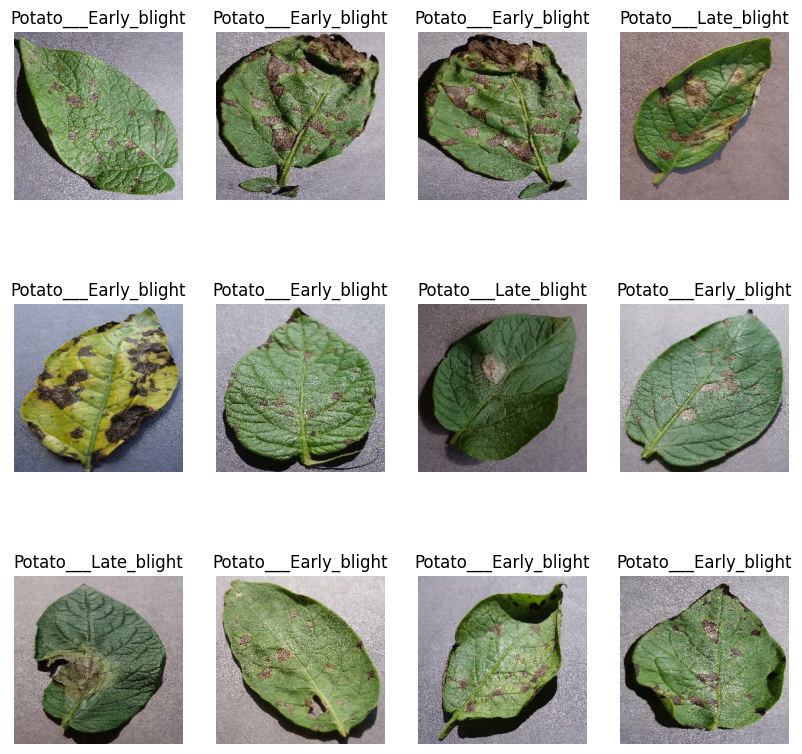

In [58]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

#### 3. Data Preparation

In [59]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [60]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [61]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### 4. Data Augmentation and Resize/Rescale Layers Built

In [62]:
shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [63]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [64]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.Input(shape=shape),
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [65]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### 5. Model Building

In [66]:
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [67]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [77]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 742ms/step - accuracy: 0.4788 - loss: 0.9413 - val_accuracy: 0.5573 - val_loss: 0.8620
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 690ms/step - accuracy: 0.6628 - loss: 0.7980 - val_accuracy: 0.7552 - val_loss: 0.5345
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 710ms/step - accuracy: 0.7973 - loss: 0.4789 - val_accuracy: 0.7865 - val_loss: 0.4658
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 743ms/step - accuracy: 0.8756 - loss: 0.3138 - val_accuracy: 0.7292 - val_loss: 0.5420
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 733ms/step - accuracy: 0.8364 - loss: 0.3848 - val_accuracy: 0.8646 - val_loss: 0.3016
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 738ms/step - accuracy: 0.9062 - loss: 0.2423 - val_accuracy: 0.8646 - val_loss: 0.3086
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.8917 - loss: 0.2492 - val_accuracy: 0.8958 - val_loss: 0.2451
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 790ms/step - accuracy: 0.9247 - loss: 0.2165 - val_accu

In [78]:
import pickle

# Save history to a file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
with open('training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

print(loaded_history['accuracy'])

In [79]:
history

In [80]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [81]:
train_acc=history.history["accuracy"]
train_loss=history.history['loss']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_accuracy']

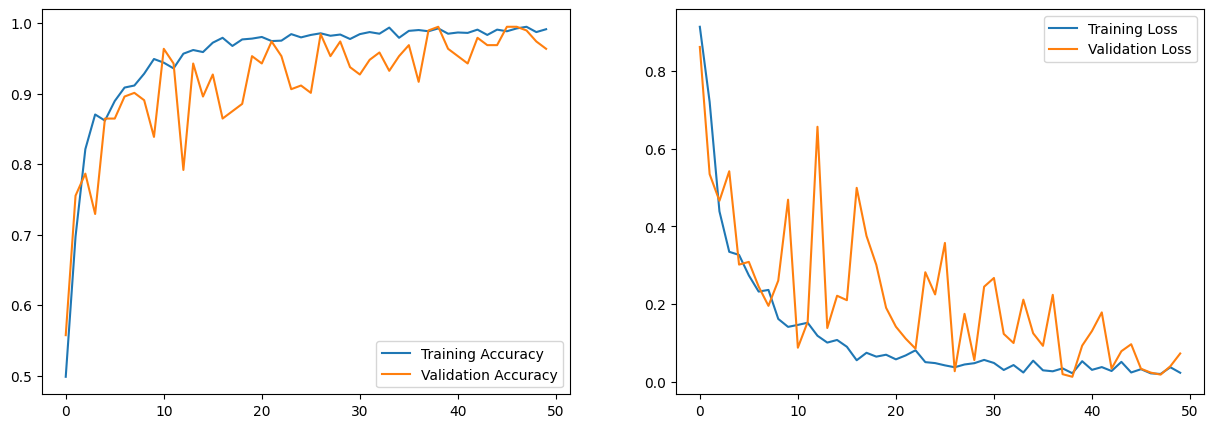

In [82]:
import seaborn as sn
fig,axes=plt.subplots(1,2,figsize=(15,5))
sn.lineplot(x=range(EPOCHS), y=train_acc, ax=axes[0], label="Training Accuracy")
sn.lineplot(x=range(EPOCHS), y=val_accuracy, ax=axes[0], label="Validation Accuracy")
sn.lineplot(x=range(EPOCHS), y=train_loss, ax=axes[1], label="Training Loss")
sn.lineplot(x=range(EPOCHS),y=val_loss, ax=axes[1], label="Validation Loss")
plt.show()

In [83]:
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
First Image's Actual Label:  Potato___Early_blight
Predicted Label:  Potato___Early_blight


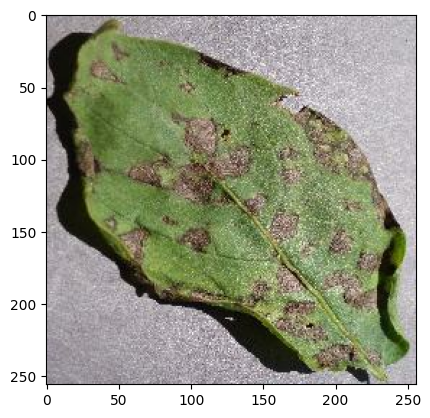

In [84]:
for image_batch, label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]
    plt.imshow(first_image)
    batch_prediction=model.predict(image_batch)
    print("First Image's Actual Label: ", class_names[first_label.numpy()])
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])
    plt.show()


In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [86]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


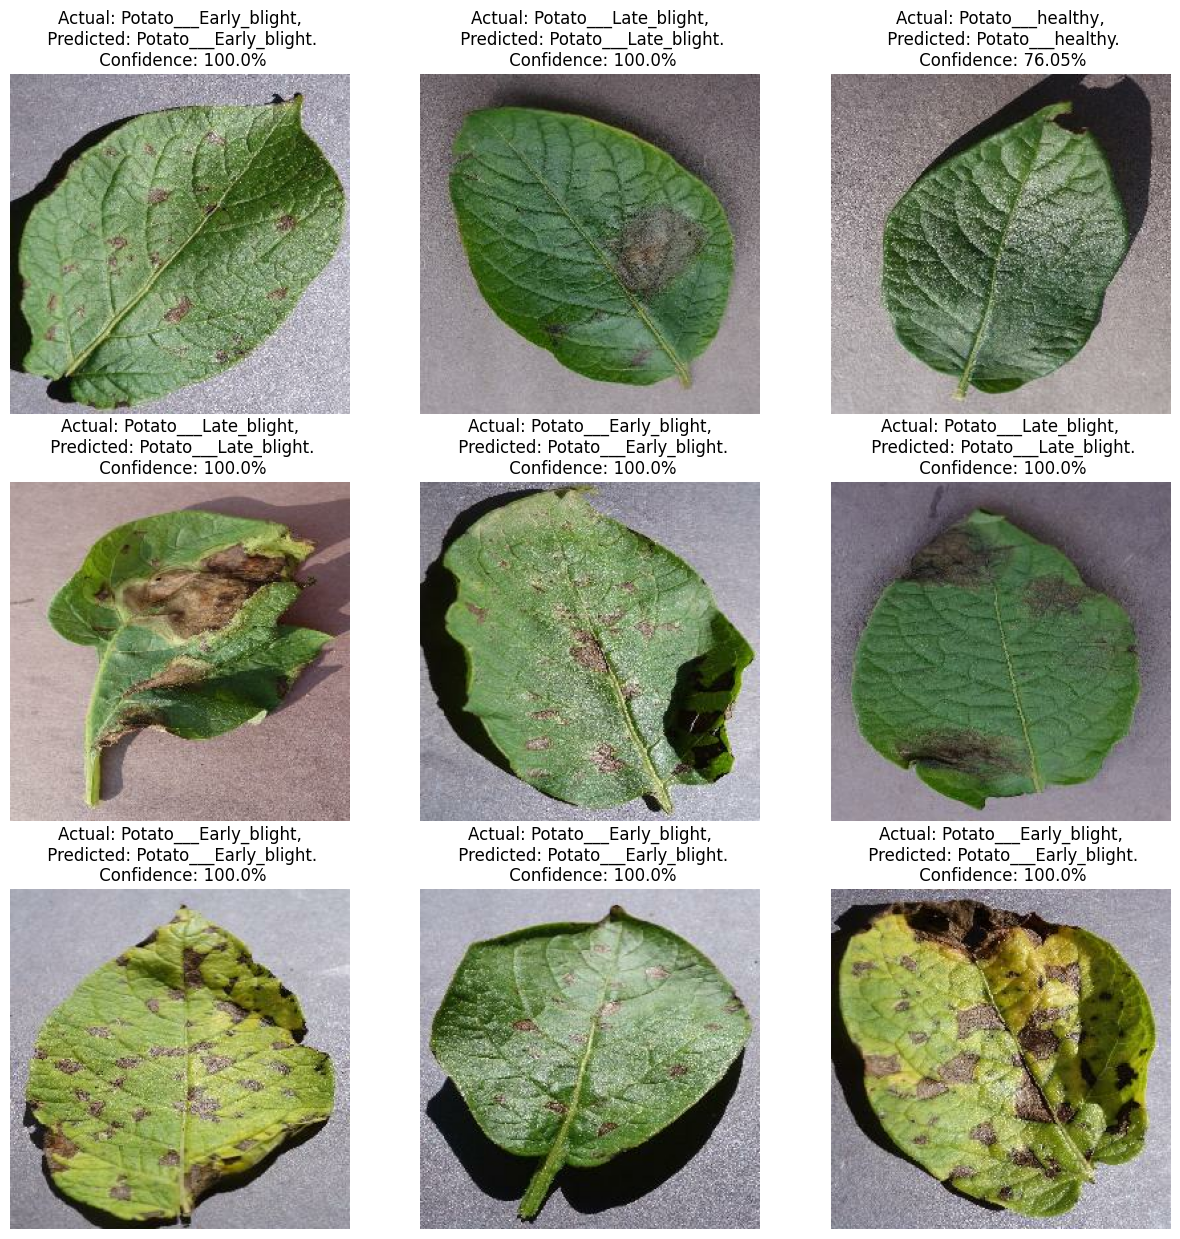

In [87]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [88]:
for images, labels in test_ds.take(1):
    print(len(labels))

32
